# FEM Modelling for STEDIN Transformer

In this part, the conducitvity of the core material is modelled as 0. Therefore, there areno eddy current effects.

## Import Packages

In [1]:
using gmsh
using LinearAlgebra
using LaTeXStrings
using Plots
using CSV
using DataFrames
using StaticArrays
using StructArrays
using BenchmarkTools
using SparseArrays
using LinearAlgebra

## Julia code

In [2]:
mutable struct FastSparseMatrix
    i_row::Vector{Int}
    i_col::Vector{Int}
    value::Vector{Float64}
    FastSparseMatrix(nelements::Int) = new(Vector{Int}(undef, 9*nelements), Vector{Int}(undef, 9*nelements), Vector{Complex{Float64}}(undef, 9*nelements))
end

function add!(fsp::FastSparseMatrix, id::Int, nodes::Vector{Int}, matrix::StaticArraysCore.SMatrix{3, 3, Float64, 9})
    for (num, (index, element)) in enumerate(pairs(matrix))
        (i, j) = Tuple(index)
        fsp.i_row[(id-1)*9 + num] = nodes[i]
        fsp.i_col[(id-1)*9 + num] = nodes[j]
        fsp.value[(id-1)*9 + num] = element
    end
    return nothing
end

function update!(fsp::FastSparseMatrix, id::Int, matrix::Matrix{Float64})
    for (num, (index, element)) in enumerate(pairs(matrix))
        fsp.value[(id-1)*9 + num] = element
    end
    return nothing
end

update! (generic function with 1 method)

In [3]:
struct meshdata
    nnodes  # number of nodes
    xnode   # array of x coordinates
    ynode   # array of y coordinates
    nelements   # number of elements
    e_group     # array containing the physical group number of each element
    elements    #  more conveniently structured connectivity array
    area    #  area of each element
    Eloc    #  Emat of each element
end

In [4]:
function get_mesh_data_tri_1e(gmsh)
    ## Get and sort the mesh nodes
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nnodes = length(node_ids)
    #..sort the node coordinates by ID, such that Node one sits at row 1
    tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
    sorted = sortslices(tosort , dims = 1);
    node_ids = sorted[:,1]
    xnode = sorted[:,2]
    ynode = sorted[:,3]

    ## Get the mesh elements
    element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
    nelements = length(element_ids[1])

    ## Create groups of elements for the subdomains
    ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 1)
    ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 2)
    ngroup3 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 3)
    ngroup4 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 4)
    ngroup5 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 5)
    ngroup6 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 6)
    ngroup7 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 7)
    ngroup8 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 8)
    ngroup9 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 9)
    ngroup10 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 10)
    ngroup11 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 11)
    ngroup12 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 12)
    ngroup13 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 13)
    ngroup14 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 14)
    ngroup15 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 15)
    ngroup16 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 16)

    e_group = zeros(1,nelements)
    area = zeros(1,nelements)
    Eloc = []
    elements = [zeros(Int, 3) for i in 1:nelements];
    for element_id in 1:nelements
        node1_id = element_connectivity[1][3*(element_id-1)+1]
        node2_id = element_connectivity[1][3*(element_id-1)+2]
        node3_id = element_connectivity[1][3*(element_id-1)+3]

        # Determine which physical group the element belongs to
        G1  = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1])+sum(node3_id.== ngroup1[1]) # Oil
        G2  = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1])+sum(node3_id.== ngroup2[1]) # Core
        G3  = sum(node1_id.== ngroup3[1])+sum(node2_id.== ngroup3[1])+sum(node3_id.== ngroup3[1]) # HV winding phase 1 left
        G4  = sum(node1_id.== ngroup4[1])+sum(node2_id.== ngroup4[1])+sum(node3_id.== ngroup4[1]) # HV winding phase 1 right
        G5  = sum(node1_id.== ngroup5[1])+sum(node2_id.== ngroup5[1])+sum(node3_id.== ngroup5[1]) # HV winding phase 2 left
        G6  = sum(node1_id.== ngroup6[1])+sum(node2_id.== ngroup6[1])+sum(node3_id.== ngroup6[1]) # HV winding phase 2 right
        G7  = sum(node1_id.== ngroup7[1])+sum(node2_id.== ngroup7[1])+sum(node3_id.== ngroup7[1]) # HV winding phase 3 left
        G8  = sum(node1_id.== ngroup8[1])+sum(node2_id.== ngroup8[1])+sum(node3_id.== ngroup8[1]) # HV winding phase 3 right
        G9  = sum(node1_id.== ngroup9[1])+sum(node2_id.== ngroup9[1])+sum(node3_id.== ngroup9[1]) # LV winding phase 1 left
        G10 = sum(node1_id.== ngroup10[1])+sum(node2_id.== ngroup10[1])+sum(node3_id.== ngroup10[1]) # LV winding phase 1 right
        G11 = sum(node1_id.== ngroup11[1])+sum(node2_id.== ngroup11[1])+sum(node3_id.== ngroup11[1]) # LV winding phase 2 left
        G12 = sum(node1_id.== ngroup12[1])+sum(node2_id.== ngroup12[1])+sum(node3_id.== ngroup12[1]) # LV winding phase 2 right
        G13 = sum(node1_id.== ngroup13[1])+sum(node2_id.== ngroup13[1])+sum(node3_id.== ngroup13[1]) # LV winding phase 3 left
        G14 = sum(node1_id.== ngroup14[1])+sum(node2_id.== ngroup14[1])+sum(node3_id.== ngroup14[1]) # LV winding phase 3 right

        if G1 == 3
            e_group[element_id] = 1;
        elseif G2 == 3
            e_group[element_id] = 2;
        elseif G3 == 3
            e_group[element_id] = 3;
        elseif G4 == 3
            e_group[element_id] = 4;
        elseif G5 == 3
            e_group[element_id] = 5;
        elseif G6 == 3
            e_group[element_id] = 6;
        elseif G7 == 3
            e_group[element_id] = 7;
        elseif G8 == 3
            e_group[element_id] = 8;
        elseif G9 == 3
            e_group[element_id] = 9;
        elseif G10 == 3
            e_group[element_id] = 10;
        elseif G11 == 3
            e_group[element_id] = 11;
        elseif G12 == 3
            e_group[element_id] = 12;
        elseif G13 == 3
            e_group[element_id] = 13;
        elseif G14 == 3
            e_group[element_id] = 14;
        end

        # Store connectivity in a convenient format
        elements[element_id] = [node1_id, node2_id, node3_id];
        
        #....retrieve the x and y coordinates of the local nodes of the current element
        xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
        ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];

        #....compute surface area of the current element
        area[element_id] = ((xnode2 - xnode1)*(ynode3-ynode1) - (xnode3-xnode1)*(ynode2 - ynode1))/2; 
        
        #....compute local matrix contribution Aloc of the current element
        Xmat = SMatrix{3,3}(xnode1, xnode2, xnode3, ynode1, ynode2, ynode3, 1, 1, 1) 
        rhs  = SMatrix{3,3}(1., 0., 0., 0., 1., 0., 0., 0., 1.) 
        Emat = MMatrix{3,3}(Xmat\rhs)
        Emat[3,:] .= 0;
        push!(Eloc,Emat)
    end

    return meshdata(nnodes, xnode, ynode, nelements, e_group, elements, area, Eloc)
end

get_mesh_data_tri_1e (generic function with 1 method)

In [5]:
function assemble_matrices(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids)
    print(" ▸ Constructing Matrices .... \r")
    start = time_ns()

    ## initialize global matrix A & B and global vector f
    if string(typeof(sourceperelement)) == "Matrix{Float64}"
        f = zeros(Float64, mesh_data.nnodes, 1)
    elseif string(typeof(sourceperelement)) == "Matrix{ComplexF64}"
        f = zeros(complex(Float64), mesh_data.nnodes, 1)
    else
        f = zeros(Float64, mesh_data.nnodes, size(sourceperelement[1])[2])
    end
    Asp = FastSparseMatrix(mesh_data.nelements)
    Bsp = FastSparseMatrix(mesh_data.nelements)

    ## Perform a loop over the elements
    for (element_id, nodes) in enumerate(mesh_data.elements)
        #....compute local vector contribution floc of the current element
        floc = mesh_data.area[element_id]/3*[1; 1; 1]*sourceperelement[element_id]

        #....compute local matrix contribution Aloc of the current element     
        Aloc = SMatrix{3,3}(mesh_data.area[element_id]*reluctivityperelement[element_id]*(transpose(mesh_data.Eloc[element_id])*mesh_data.Eloc[element_id]));
        Bloc = SMatrix{3,3}(mesh_data.area[element_id] / 3 * conductivityperelement[element_id] * omega * SMatrix{3,3}(1I))

        # Add local contribution to A & B
        add!(Asp, element_id, nodes, Aloc);
        add!(Bsp, element_id, nodes, Bloc);

        #....and add local contribution to global matrices
        f[nodes,:] += floc;
    end

    A = sparse(Asp.i_row, Asp.i_col, Asp.value, mesh_data.nnodes, mesh_data.nnodes, +);
    B = sparse(Bsp.i_row, Bsp.i_col, Bsp.value, mesh_data.nnodes, mesh_data.nnodes, +);

    ## Handle the boundary conditions
    A[bnd_node_ids,:] .= 0;
    A[bnd_node_ids,bnd_node_ids] = Diagonal(ones(size(bnd_node_ids)))
    B[bnd_node_ids,:] .= 0;
    B[bnd_node_ids,bnd_node_ids] = Diagonal(ones(size(bnd_node_ids)))
    f[bnd_node_ids] .= 0;

    elapsed = round((time_ns() - start)/10^9, digits=2)
    println(" ✓ Matrices constructed ("*string(elapsed)*" seconds)                               ")

    return A, B, f
end

assemble_matrices (generic function with 1 method)

In [6]:
function fem(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, coil_voltage, ext_resistance, ext_inductance)
    ## Assemble A, B, and f Matrices
    @time A, B, f = assemble_matrices(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids)

    A = A + 1im*B;

    ## Circuit Equations
    K = [A -f; 1im*omega*f' Diagonal(ext_resistance)+1im*omega*Diagonal(ext_inductance)]
    T = [zeros(mesh_data.nnodes); coil_voltage]
    
    print(" ▸ Computing solution .... \r")
    start = time_ns()
    ## Compute the numerical solution
    K = factorize(K)
    u = K\T
    elapsed = round((time_ns() - start)/10^9, digits=2)
    println(" ✓ Solution computed ("*string(elapsed)*" seconds)                               ")

    return u
end

fem (generic function with 1 method)

In [7]:
function B_norm(mesh_data, u, reluctivityperelement)    
    Bx = zeros(Complex{Float64}, mesh_data.nelements);
    By = zeros(Complex{Float64}, mesh_data.nelements);

    u = u[1:mesh_data.nnodes]

    ## Perform a loop over the elements
    for (element_id, nodes) in enumerate(mesh_data.elements)
        Emat = mesh_data.Eloc[element_id];
        c = u[[nodes[1], nodes[2], nodes[3]]];
        Bx[element_id] = sum(c .* Emat[2,:]);
        By[element_id] = -sum(c .* Emat[1,:]);
    end

    B = (Bx.^2 + By.^2).^0.5

    return B
end

B_norm (generic function with 1 method)

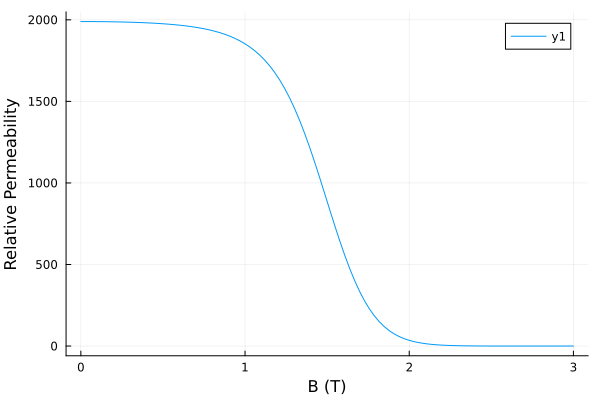

In [8]:
# Plot of mu vs B
mu0 = 4e-7 * pi;
function mu_func(B)
    k1 = 3.8;
    k2 = 2.17;
    k3 = 396.2;
    mu0 = 4e-7 * pi;
    v = k1 * exp(k2*B^2) + k3;
    return (1 ./ v)
end

B = collect(range(0, 3.0, 100))
plot(B,mu_func.(B)/mu0)
xlabel!("B (T)")
ylabel!("Relative Permeability")

In [9]:
gmsh.initialize()

## Read mesh from file
print(" ▸ Reading mesh file .... \r")
start = time_ns()
gmsh.open("../Geometry/mesh/stedin_transformer.msh")
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Mesh file loaded ("*string(elapsed)*" seconds)                               ")

print(" ▸ Generating required mesh data .... \r")
start = time_ns()
mesh_data = get_mesh_data_tri_1e(gmsh)
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Mesh data generated ("*string(elapsed)*" seconds)                               ")

print(" ▸ Setting initial parameters .... \r")
start = time_ns()
Ip = 17.54;   # Primary peak phase current
Is = 777.62;  # Secondary peak phase current
Vp = 15202.40;   # Primary peak phase voltage
Vs = 342.93;     # Secondary peak phase voltage
Np = 266;
Ns = 6;

omega = 2*pi*50;  # Frequency

# HV winding dimensions (all phases left/right are identical)
wwhv = 3e-2;
hwhv = 74e-2;
mwhv = 14.75e-2;
Awhv = wwhv * hwhv;

# LV winding dimensions (all phases left/right are identical)
wwlv = 2e-2;
hwlv = 74e-2;
mwlv = 11.25e-2;
Awlv = wwlv * hwlv;

# Calculate turn density in the windings
Tp = Np / Awhv;
Ts = Ns / Awlv;

# Source turn density T
# One term for each of the windings, with a positive and negative part
sourcefunction(group_id) = [Tp*(1*(group_id==3))  -Tp*(1*(group_id==4)) Tp*(1*(group_id==5))  -Tp*(1*(group_id==6)) Tp*(1*(group_id==7))  -Tp*(1*(group_id==8))   Ts*(1*(group_id==9))  -Ts*(1*(group_id==10)) Ts*(1*(group_id==11))  -Ts*(1*(group_id==12)) Ts*(1*(group_id==13))  -Ts*(1*(group_id==14))];
sourceperelement = map(sourcefunction, mesh_data.e_group);

# Source voltage V
# One term for each of the windings, with a positive and negative part
coil_voltage = [Vp*exp(1im*-2pi/3); Vp*exp(1im*-2pi/3); Vp; Vp; Vp*exp(1im*2pi/3); Vp*exp(1im*2pi/3); 0; 0; 0; 0; 0; 0];

# External resistance Rext
# One term for each of the windings, with a positive and negative part
Rp = 150.655
Rs = 1.2999e-3
ext_resistance = [Rp; Rp; Rp; Rp; Rp; Rp; Rs; Rs; Rs; Rs; Rs; Rs];
    
# External resistance Rext
# One term for each of the windings, with a positive and negative part
ext_inductance = 1e-3.*[1; 1; 1; 1; 1; 1; 1; 1; 1; 1; 1; 1];

# Relative permeability model
mu0 = 4e-7 * pi;
mur = 2500;       # Relative permeability of the core
reluctivityfunction(group_id) = (1 / mu0) + (1/(mu0*mur) - 1/mu0) * (group_id == 2)
reluctivityperelement = map(reluctivityfunction, mesh_data.e_group);

# Conductivity
conductivityfunction(group_id) = 0;
conductivityperelement = map(conductivityfunction, mesh_data.e_group);

# Handle the boundary conditions
bnd_node_ids, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1);

elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Initial parameters set ("*string(elapsed)*" seconds)                               ")

core_elements = findall(x->x==2, mesh_data.e_group)
L = LinearIndices(mesh_data.e_group)
core_elements = L[core_elements]
    
## Threshold value for the error
threshold = 1e-3
alpha = 0.9

u, Bx, By, B, Hx, Hy, H, mag_energy = (0, 0, 0, 0, 0, 0, 0, 0);

u = fem(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, coil_voltage, ext_resistance, ext_inductance);
u_hist = u
u_prev = u

for loop = 1:100
    u_prev = u;
    u_hist = u_hist * alpha + u * (1-alpha)
    
    ## Compute Bnorm
    B = B_norm(mesh_data, u_hist, reluctivityperelement)    

    ## Assign new value of mur
    reluctivityperelement[core_elements] = 1 ./ mu_func.(abs.(B[core_elements]));
    
    # Calculate the vector potential
    u = fem(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, coil_voltage, ext_resistance, ext_inductance);
    
    ## Check the error with the threshold values
    if norm(u[1:mesh_data.nnodes]-u_prev[1:mesh_data.nnodes]) <= threshold
        break;
    end
end

gmsh.finalize()

Info    : Reading '../Geometry/mesh/stedin_transformer.msh'...
Info    : 168 entities
Info    : 10385 nodes
Info    : 20768 elements
Info    : Done reading '../Geometry/mesh/stedin_transformer.msh'
 ✓ Mesh file loaded (0.15 seconds)                               
 ✓ Mesh data generated (9.26 seconds)                               
 ✓ Initial parameters set (0.76 seconds)                               
 ✓ Matrices constructed (2.31 seconds)                               
  2.311298 seconds (4.02 M allocations: 242.868 MiB, 6.63% gc time, 89.73% compilation time)
 ✓ Solution computed (1.7 seconds)                               
 ✓ Matrices constructed (0.19 seconds)                               
  0.189892 seconds (514.40 k allocations: 71.471 MiB, 15.89% gc time)
 ✓ Solution computed (0.19 seconds)                               
 ✓ Matrices constructed (0.19 seconds)                               
  0.186617 seconds (514.40 k allocations: 71.471 MiB, 13.86% gc time)
 ✓ Solution compute